# **SISTEMA DE DETECCIÓN DE DISTANCIAMIENTO SOCIAL**
### Proyecto Final de Visión Artificial.
Este proyecto permite detectar en una imagen o video, los peatones que guardan la distancia necesaria entre ellos para acatar las normas de distanciamiento social, que pretende prevenir el incremento de contangiados por el COVID-19.

Nuestra solución contiene tres pasos principales:
  - Calibración.
  - Detección.
  - Evaluación de Distancia Mínima.

**Github Documentado:**
https://github.com/jjrodcast/SocialDistanceDetector

**Video Resultado (30 seg):**
https://www.youtube.com/watch?v=XxR2PXG9Zgk&feature=youtu.be

## **1. Importamos Librerías y Funciones propias.**
En esta sección, importamos las **librerías** necesarias para las operaciones que se realizarán. Asi mismo, se importan **dos archivos de funciones ("functions.py" y "view.py")** que hemos diseñado para la solución. Finalmente, se cargan los archivos necesarios para **inicializar la CNN (pesos, configuración y nombres de clases)**.

In [0]:
#Importamos Librerías:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt
#Importamos Funciones Propias:
from utils.functions import *
from utils.view import *

In [3]:
#Importamos configuración, nombres de clases y pesos de la CNN:
!wget "https://pjreddie.com/media/files/yolov3.weights"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
!mkdir models 
!mv yolov3.weights models/yolov3.weights
!mv yolov3.cfg models/yolov3.cfg
!mv coco.names models/coco.names

--2020-05-17 03:40:25--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights        7%[>                   ]  16.91M   307KB/s    eta 19m 50s^C
--2020-05-17 03:42:00--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2020-05-17 03:42:00 (82.3 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2020-05-17 03:4

## **2. Calibración.**
En esta sección se calcula la matriz de homografía para transformar la vista en perspectiva, obtenida por la cámara, hacia una vista de arriba hacia abajo. Esta vista es también llamada "Bird's Eye View". Asumiendo que la cámara se mantiene estática, la matriz se calcula en base a un solo frame del video y se seleccionan cuatro puntos de referencia que serán mapeados hacia la vista "Bird's Eye View".

#### **2.1 -** Selección de Puntos en Imagen de Referencia.

Image size:  (1080, 1920, 3)


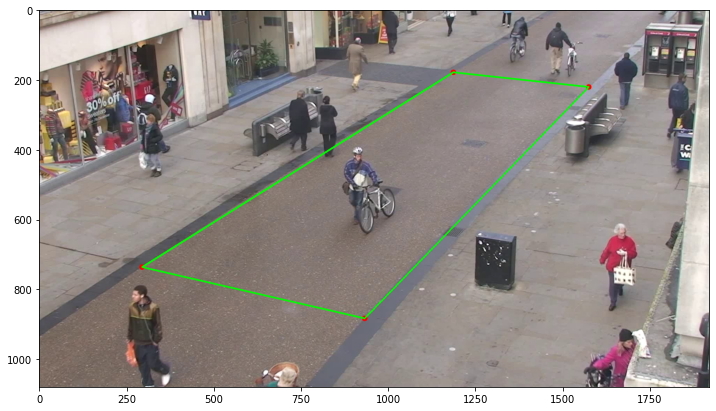

In [9]:
#Obtenemos el primer frame del video como referencia.
original = cv2.cvtColor(cv2.imread('multimedia/calibration_frame.jpg'), cv2.COLOR_BGR2RGB)
image_calibration = original.copy()
image_copy = original.copy()

#Seleccionamos manualmente 4 puntos en la imagen. Utilizamos la vereda como referencia.
source_points = np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]])

#Dibujamos los puntos seleccionados en la imagen:
for point in source_points:
    cv2.circle(image_calibration, tuple(point), 8, (255, 0, 0), -1)

#Dibujamos las líneas de unión entre los puntos para formar el trapecio:
points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(image_calibration, [points], True, (0,255,0), thickness=4)

#Graficamos la imagen:
print("Image size: ", original.shape)
plt.figure(figsize=(12, 12))
plt.imshow(image_calibration)
plt.show()

#### **2.2 -** Cálculo de Matriz de Homografía.

In [10]:
#Consideramos una imagen final de tamaño 4500x3000 pixels:
dst_size=(4500,3000)

#Obtenemos los puntos de referencia de la imagen original:
src=np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]])

#Obtenemos los puntos de destino, como una proporción de la imagen de destino:
dst=np.float32([(0.57,0.42), (0.65, 0.42), (0.65,0.84), (0.57,0.84)])

img_size = np.float32([(image_calibration.shape[1],image_calibration.shape[0])])

#Obtenemos los puntos de destino al multiplicar la proporción por el tamaño de la imagen:
dst = dst * np.float32(dst_size)

#Calculamos la matriz de homografía para la transformación:
H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

The perspective transform matrix:
[[ 1.14199333e+00  6.94076400e+00  8.88203441e+02]
 [-5.13279159e-01  7.26783411e+00  1.02467130e+03]
 [ 9.79674124e-07  1.99580075e-03  1.00000000e+00]]


#### **2.3 -** Visualización de "Bird's Eye View".

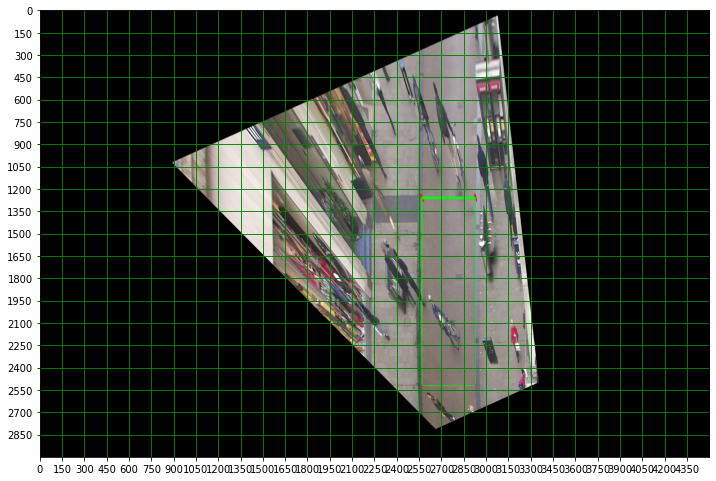

In [11]:
#Aplicamos Warp Perspective para transformar la imagen con la matriz de homografía obtenida.
warped = cv2.warpPerspective(image_calibration, H_matrix, dst_size)

#Graficamos la imagen transformada:
plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.xticks(np.arange(0, warped.shape[1], step=150))
plt.yticks(np.arange(0, warped.shape[0], step=150))
plt.grid(True, color='g', linestyle='-', linewidth=0.9)
plt.show()

## **3. Detección.**
En esta sección se realiza la detección de los peatones, el cálculo de los puntos de importancia que identifican la posición de cada peaton, la tranformación de estos puntos hacia la vista "Bird's Eye View" y el cálculo de la distancia entre los puntos transformados para determinar los que incumplen la separación de distancia mínima.

#### **3.1 -** Configuración CNN-YOLOv3.
Se escogió la arquitectura YOLOv3-608 con un mAP de 57.9 y procesamiento de 20 FPS por que se desea tener un procesamiento lo más cercano a efectuarse en tiempo real.
Se escogió el valor de distancia mínima como 115 pixels después de varios ensayos de prueba y error.

In [0]:
#Definimos los parámetros de confidencia para la CNN:
confidence_threshold = 0.5
nms_threshold = 0.4

#Definimos la distancia mínima permitida como 115 pixels:
min_distance = 115
width = 608
height = 608

#Obtenemos la ruta de los archivos de configuración de la CNN:
config = 'models/yolov3.cfg'
weights = 'models/yolov3.weights'
classes = 'models/coco.names'

#Leemos la clases de la CNN:
with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

#Creamos el modelo de la CNN y obtenemos las últimas capas de detección:
model = create_model(config, weights)
output_layers = get_output_layers(model)

#### **3.2 -** Detección de Peatones y Evaluación de Distancia Mínima.
1. Se escala la imagen de entrada. **Función: blob_from_image()**
2. Se obtienen los recuadros de detección. **Función: predit()**
3. Se aplica "Non Maximum Suppression" para eliminar falsos positivos. **Función: non_maximum_suppression()**
4. Se transforma cada punto central inferior correspondiente a los recuadros de detección hacia la vista "Bird's Eye View". **Función: people_distances_bird_eye_view()**
5. Se evalúa la distancia entre los puntos transformados en la vista "Bird's Eye View", tomando como referencia una distancia mínima de 115 pixels para ser considerado como peligrosa. **Función: people_distances_bird_eye_view()**
6. Se grafica la imagen original coloreando los recuadros de detección como rojos si la distancia calculada es menor a 115 pixels. **Función: draw_new_image_with_boxes()**

In [0]:
#Escalamos la imagen:
blob = blob_from_image(image_copy, (width, height))
#Obtenemos los recuadros de detección:
outputs = predict(blob, model, output_layers)
#Aplicamos Non Maximum Suppression para mejorar la detección:
boxes, nms_boxes, class_ids = non_maximum_suppression(image_copy, outputs, confidence_threshold, nms_threshold)
#Obtenemos los recuadros de detección unicamente para las clases "person":
person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')
#Evaluamos la distancia:
good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
#Generamos la imagen final con la evaluación de distancia:
new_image  = draw_new_image_with_boxes(image_copy, good, bad, min_distance, draw_lines=True)
plt.figure(figsize=(12,12))
plt.imshow(new_image)
plt.show()

#### **3.2 -** Proyección de Puntos en "Bird's Eye View".
Se grafica la vista "Bird's Eye View" coloreando los puntos como rojos si la distancia calculada es menor a 115 pixels y verdes caso contrario. **Función: generate_bird_eye_view()**

In [0]:
#Obtenemos la lista de puntos verdes y rojos:
green_points = [g[6:] for g in good]
red_points = [r[6:] for r in bad]

#Generamos la vista "Bird's Eye View" con los puntos evaluados por distancia:
bird_eye_view = generate_bird_eye_view(green_points, red_points)
plt.figure(figsize=(6,6))
plt.imshow(bird_eye_view)
plt.show()

#### **3.3 -** Resultado Final - por Frame".
Muestra la imagen final que incluye la vista original con los recuadros de detección y los puntos coloreados según la evaluación de distancia en la imagen original y la vista "Bird's Eye View" respectivamente.

In [0]:
#Generamos el marco que contiene los textos y el logo:
picture = generate_picture()

#Ingresamos en el marco previo, la imagen original y la vista "Bird´s Eye View":
img_final = generate_content_view(picture, new_image, bird_eye_view)
plt.figure(figsize=(20,20))
plt.imshow(img_final)
plt.show()

## **4. Procesamiento de Video.**
Finalmente, en esta última sección, se presenta el código para realizar el procesamiento del video "TownCentre", aplicando los mismos pasos mostrados previamente para cada uno de los frames del video.

In [0]:
%%time
confidence_threshold = 0.5
nms_threshold = 0.4
min_distance = 115
width = 608
height = 608

config = 'models/yolov3.cfg'
weights = 'models/yolov3.weights'
classes = 'models/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

writer = None
W = 2604
H = 1254    
  
model = create_model(config, weights)
output_layers = get_output_layers(model)

picture = generate_picture()

video = cv2.VideoCapture('multimedia/TownCentre-test.mp4')

while True:
  
  _,frame = video.read()
  
  if frame is None:
      break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('multimedia/output.avi', fourcc, 30, (W, H), True)

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  blob = blob_from_image(image, (width, height))
  outputs = predict(blob, model, output_layers)
  boxes, nms_boxes, class_ids = non_maximum_suppression(image, outputs, confidence_threshold, nms_threshold)
  person_boxes = get_domain_boxes(coco_classes, class_ids, nms_boxes, boxes, domain_class='person')

  good, bad = people_distances_bird_eye_view(person_boxes, min_distance)
  new_image  = draw_new_image_with_boxes(image, good, bad, min_distance, draw_lines=True)
  
  green_points = [g[6:] for g in good]
  red_points = [r[6:] for r in bad]

  bird_eye_view = generate_bird_eye_view(green_points, red_points)
  output_image = generate_content_view(picture, new_image, bird_eye_view)

  if writer is not None:
    plt.figure(figsize=(20,20))
    plt.imshow(output_image)
    plt.show()  
    writer.write(output_image[:,:,::-1])
      
if writer is not None:
  writer.release()

video.release()